### This code is to implement bi-directional sweeps in the HD attractor network

In [11]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from network import HD_cell

import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot functions

In [141]:

def plot_populationsweep(ax, t, Head_direction, bump_activity):
    
    labelsize=10
    ticksize=8
    # imshow and smooth
    ax.imshow(bump_activity.T*100, aspect='auto', extent=[t[0], t[-1], -bm.pi, bm.pi], cmap='inferno', origin='lower')
    
    #plot the head direction as a line
    ax.plot(t, Head_direction, color='white', lw=2)
    
    #add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Activity (Hz)', fontsize=ticksize)
    #set ticks
    cbar.ax.set_yticks([0, int(np.max(bump_activity)*100/10)*10])

    cbar.ax.tick_params(labelsize=ticksize)
    
    #xticks
    ax.set_xticks([t[0], t[-1]])
    ax.set_xticklabels([t[0]-t[0], np.round((t[-1]-t[0])/1000,1)])
    #yticks
    ax.set_yticks([-bm.pi, 0, bm.pi])
    ax.set_yticklabels([r'$0\degree$', r'$180\degree$', r'$360\degree$'])
    
    #label
    ax.set_xlabel('Time (s)', fontsize=labelsize)
    ax.set_ylabel('Direction', fontsize=labelsize)
    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

def plot_phaseprecession(ax, cellindex, HD_activity, Head_direction, theta_phase, addfitline=True):
    
    labelsize=10
    ticksize=8
    
    hd_spike = []
    tp_spike = []
    #for each Head_direction, theta_phase pair, generate a spike event based on a Poisson process with mean value as r_HD
    for i in range(len(Head_direction)):
        hd = Head_direction[i,0]
        tp = theta_phase[i]
        r = HD_activity[i, cellindex]
        #genertae a spike event based on a Poisson process with mean value as r
        spikes = np.random.poisson(r, 1)
        if spikes > 0:
            #save hd and tp
            hd_spike.append(hd)
            tp_spike.append(tp)
    hd_spike = np.array(hd_spike)
    tp_spike = np.array(tp_spike)

    ax.scatter(hd_spike, tp_spike, s=3, color='black', alpha=0.1)

    ax.scatter(hd_spike, tp_spike+2*np.pi, s=3, color='black', alpha=0.1)
    
    ax.axvline(x=0, color='#009FB9', linestyle='--', linewidth=2, label = 'preferred direction')

    circ_lin_corr, pval, slope, phi0, RR = cl_corr(hd_spike, tp_spike, min_slope=-1, max_slope=0, bootstrap_iter=3000, return_pval=True)
    
    if addfitline:
        # Plot the circular-linear regression
        x = np.linspace(-np.pi, np.pi, 100)
        y = 2 * np.pi * slope * x + phi0
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 4*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #substrac intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)       

    # ax[0].set_xlabel('Head direction')
    ax.set_xlabel('Turning angle', fontsize=labelsize)
    ax.set_ylabel('Theta phase', fontsize=labelsize)
    #activity colorbar
    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_xticks([-0.5*np.pi, 0, 0.5*np.pi])
    ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$\pi/2$'])
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0, 2*np.pi, 4*np.pi])
    ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

    #tick size
    ax.tick_params(axis='both', which='major', labelsize=ticksize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax, circ_lin_corr, slope

## Section 1: define the network

In [99]:
bm.set_dt(1.)

HD_net = HD_cell(num=100, 
                noise_stre=0.6, 
                tau=10., tau_v=100., 
                k=1., mbar=15, a=0.4, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)

def run_HDNet(i, Head_direction, angular_velocity_gain):  # 20 x size

    T_theta = 100 #ms
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    #calculate TheataModulator at time step i
    ThetaModulator_HD = 1+(0.2+0.02*angular_velocity_gain)*bm.cos(theta_phase*2*bm.pi)
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center
    bump_activity = HD_net.r
    return Internal_direction, bump_activity, theta_phase

## Section 2: simulate the HD network when head direction is fixed

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:00<00:00, 16085.41it/s]


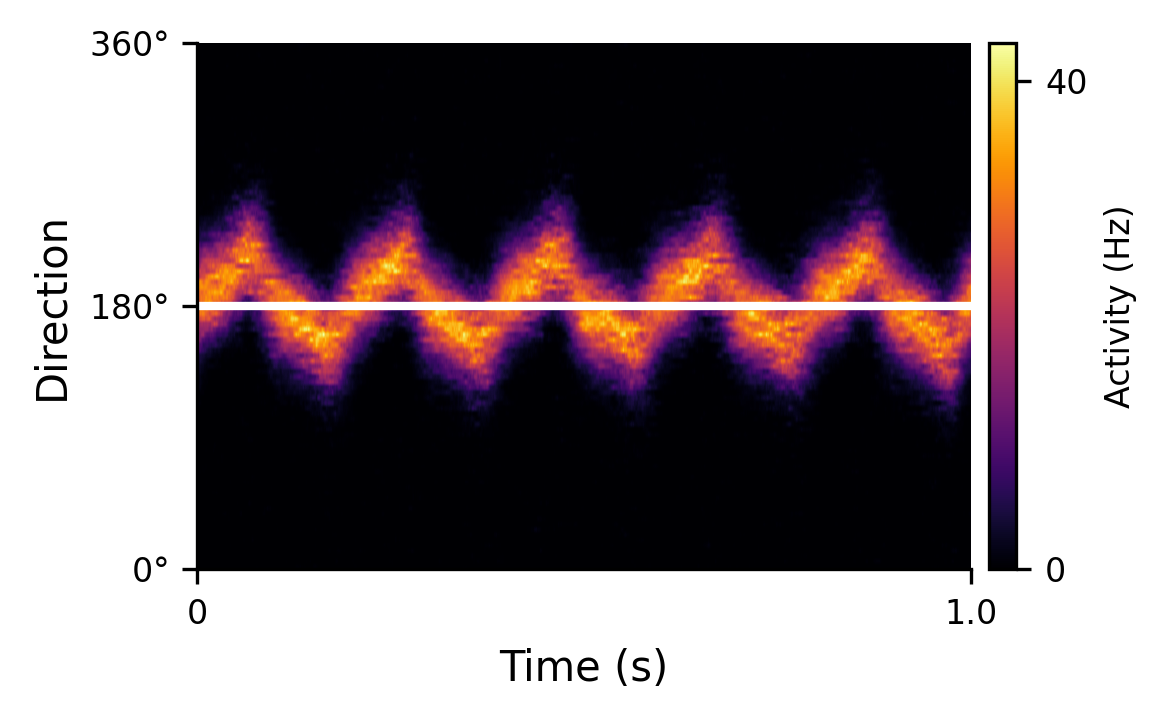

In [91]:
numT = 4000 #ms

time_steps = np.arange(numT)
angular_velocity_gain = 0.
Head_direction = angular_velocity_gain*bm.pi*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
angular_velocity_gain = np.ones_like(Head_direction)*angular_velocity_gain
bump_center, bump_activity, theta_phase = bm.for_loop(run_HDNet, (time_steps, Head_direction, angular_velocity_gain), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 1000
end = 2000+1


#polor plot in axs[1]
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=300)
ax = plot_populationsweep(ax, 
                        time_steps[start:end], 
                        Head_direction[start:end], 
                        bump_activity[start:end])
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_sweep_static.pdf', dpi=300)

## Section 3: simulate the network when head direction is rotating at a constant speed

100%|██████████| 4000/4000 [00:00<00:00, 17146.52it/s]


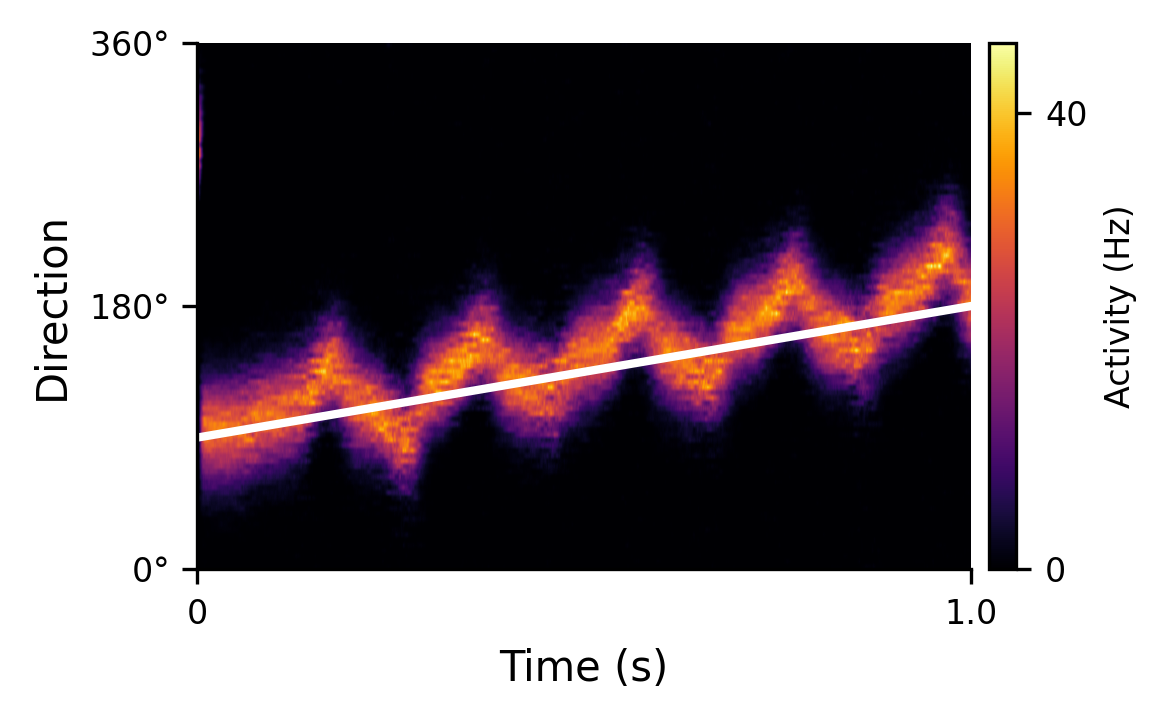

In [110]:
numT = 4000
time_steps = np.arange(numT)
#chaging head direction, mimicking the animal turning
angular_velocity_gain = 2
Head_direction = angular_velocity_gain*bm.pi*bm.arange(numT)/numT
#wrap to 0 to 2pi
Head_direction = bm.mod(Head_direction, 2*bm.pi) - bm.pi/2
angular_velocity_gain = np.ones_like(Head_direction)*angular_velocity_gain
bump_center, bump_activity, theta_phase = bm.for_loop(run_HDNet, (time_steps, Head_direction, angular_velocity_gain), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 0
end = 1000+1
#polor

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=300)
ax = plot_populationsweep(ax, 
                        time_steps[start:end], 
                        Head_direction[start:end], 
                        bump_activity[start:end])
plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_sweep_rotating.pdf', dpi=300)

## Section 4: plot phase precession of turning angle

In [161]:
def simulate(angular_velocity_gain=1, offset=-0.08, theta_mod_base=0.1):
    
    '''
    0.5, 15, 1: precession HD
    0., 0,, 1: normal HD (no theta tuned)
    3.5, 0, 1: theta tuned no precession 
    '''

    # run network
    
    HD_net = HD_cell(num=100, 
                    noise_stre=0.6, 
                    tau=10., tau_v=100., 
                    k=1., mbar=15, a=0.4, A=3., J0=4., 
                    z_min=-bm.pi, z_max=bm.pi)

    def run_HDNet(i, Head_direction):  # 20 x size

        T_theta = 100 #ms
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta
        #calculate TheataModulator at time step i
        ThetaModulator_HD = 1+(theta_mod_base+0.1*angular_velocity_gain)*bm.cos(theta_phase*2*bm.pi)
        #ThetaModulator_HD = 1+0*bm.cos(theta_phase*2*bm.pi)
        HD_net.step_run(i, Head_direction, ThetaModulator_HD)
        Internal_direction = HD_net.center
        bump_activity = HD_net.r
        return Internal_direction, bump_activity, theta_phase    
    
    
    angular_velocity = angular_velocity_gain*np.pi/(1e3)
    
    if angular_velocity_gain ==0:
        numT = 4000
        x0 = offset*np.pi
        start = int(3*numT/4)
        end = numT
    else:
        N = 40
        numT = int(N*2*np.pi/(bm.dt*angular_velocity))
        x0 = -np.pi
        onecycleT = numT/(N)
        # start = int(numT - 0.99*onecycleT)
        # end = int(numT - 0.2*onecycleT)
        start = int(0.1*onecycleT)
        end = int(0.9*onecycleT)        
    time_steps = np.arange(numT)

    def generate_traj_hd(x0, v, T):
        x = []
        xt = x0
        for i in range(T):
            xt = xt + v * (1 + 2*np.random.randn(1)) * bm.dt
            if xt > np.pi:
                xt -= 2 * np.pi
            if xt < -np.pi:
                xt += 2 * np.pi
            x.append(xt)
        return np.array(x)

    Head_direction = generate_traj_hd(x0=x0, v=angular_velocity, T=numT)
    # plt.figure()
    # plt.plot(Head_direction)

    center_HD, HD_activity, theta_phase = bm.for_loop(
        run_HDNet, (time_steps, Head_direction), progress_bar=True
    )

    theta_phase = theta_phase*2*np.pi
    max_bump_activity = np.max(HD_activity, axis=1)
    
    return start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase




100%|██████████| 80000/80000 [00:00<00:00, 106168.08it/s]


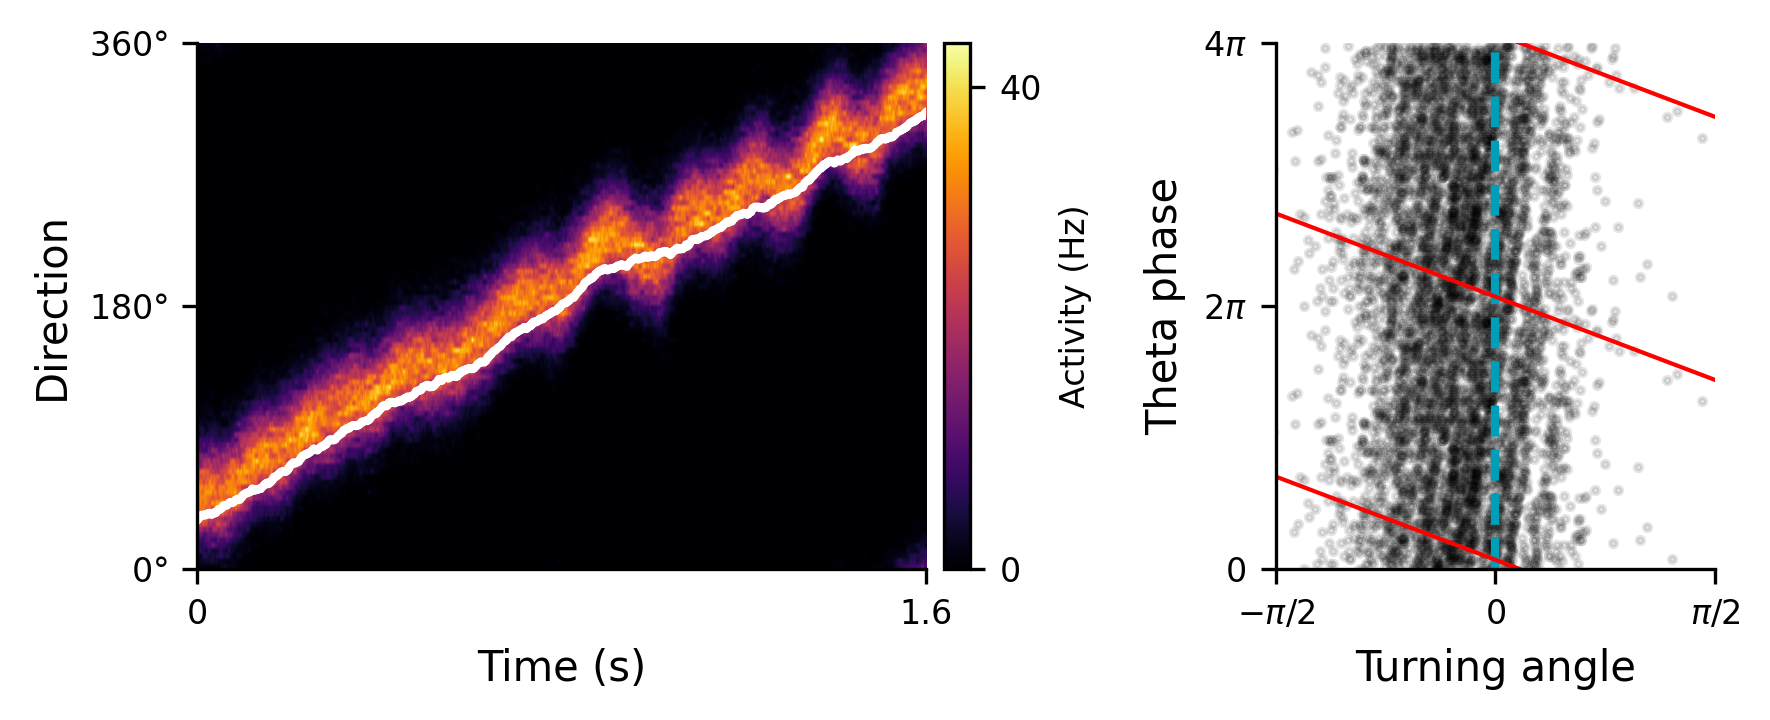

In [162]:
results = simulate(angular_velocity_gain=1, offset=-0.08, theta_mod_base=0.2)
start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

fig, axs  = plt.subplots(1, 2, figsize=(6, 2.5), dpi=300, width_ratios=[2, 1])

ax = axs[0]
#plot population sweeps
ax = plot_populationsweep(ax, 
                        time_steps[start:end], 
                        Head_direction[start:end], 
                        HD_activity[start:end])

ax = axs[1]
cellindex = 50
ax, clr, slope = plot_phaseprecession(ax, cellindex, HD_activity, Head_direction, theta_phase)

plt.tight_layout()

## Section 5: check phase precession with various angular speed

100%|██████████| 119999/119999 [00:01<00:00, 118221.55it/s]


0.061944524763356004 -0.49627190340657956


100%|██████████| 100000/100000 [00:00<00:00, 112195.88it/s]


0.07317401714735505 -0.4974612128153367


100%|██████████| 85714/85714 [00:00<00:00, 109515.63it/s]


0.12840636267365138 -0.4581228755486227


100%|██████████| 75000/75000 [00:00<00:00, 104010.16it/s]


0.3049005295299913 -0.37750440470448215


100%|██████████| 66666/66666 [00:00<00:00, 99242.27it/s] 


0.27564919882849465 -0.2718292257972859


100%|██████████| 60000/60000 [00:00<00:00, 96683.42it/s] 


0.35908558467779084 -0.27100279901400853


100%|██████████| 54545/54545 [00:00<00:00, 94259.60it/s] 


0.35242531000421407 -0.2708305657973679


100%|██████████| 50000/50000 [00:00<00:00, 90744.95it/s] 


0.321740408565123 -0.25503644320575136


100%|██████████| 46153/46153 [00:00<00:00, 88136.08it/s] 


0.30008421426528625 -0.27613864841924457


100%|██████████| 42857/42857 [00:00<00:00, 85422.64it/s]


0.3667524478854962 -0.30299311895883907


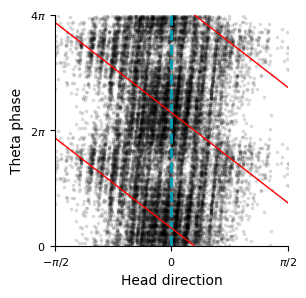

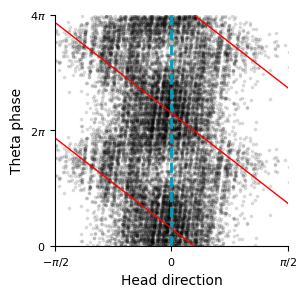

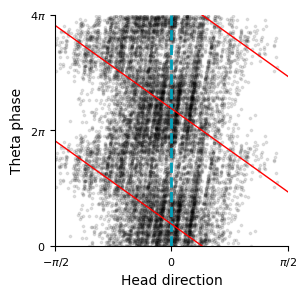

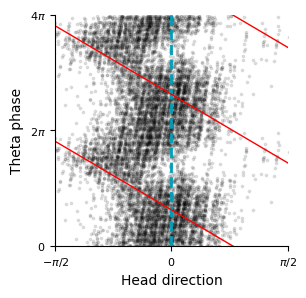

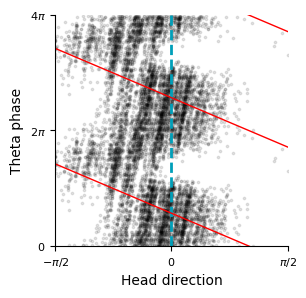

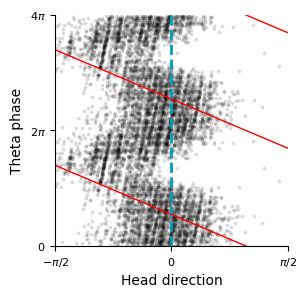

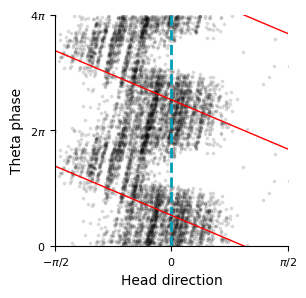

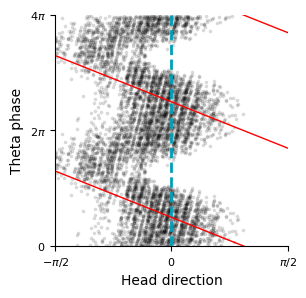

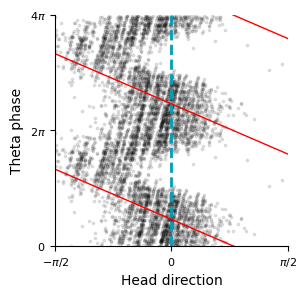

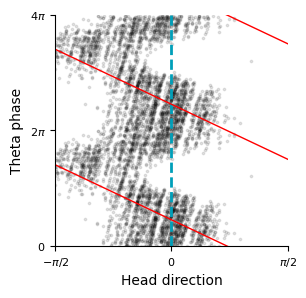

In [49]:
for angular_gain in np.arange(0.5,1.5,0.1):
    results = simulate(angular_velocity_gain=angular_gain)
    start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

    fig, ax  = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
    cellindex = 50
    ax, clr, slope = plot_phaseprecession(ax, cellindex, HD_activity, Head_direction, theta_phase)
    print(clr, slope)